Nous allons ici établir un modèle de scoring sur les clients afin de déterminer la probabilité de churn et ensuite établir un profil type des clients risqués (client probable de résilier).

In [0]:
import pandas as pd 
import numpy as np 

In [0]:
data = pd.read_csv('Telco_Churn.csv', sep=';')

In [0]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [0]:
data.shape

(7043, 21)

In [0]:
data.info()
# On voit donc ici que nous n'avons pas de valeurs nulles dans nos données 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Avec les infos générales sur notre Dataset on peut remarquer que l'on a pas de vide et que l'on a majoritairement des colonnes catégorielles (que l'on encodera par la suite dans notre étape de préprocessing). Cela nous permet déjà d'affirmer que l'on va privilégier pour l'apprentissage automatique de nos données le modèle CatBoostClassifier, modèle le mieux adapter à la fois pour notre problèmatique et pour le type de donnée que l'on a.

In [0]:
# On va transformer notre variable cible en colonne qualitative (avec exclusivement des 0 et des 1)

def transform_target(x):
    if x == 'Yes':
        return 1
    else:
        return 0
data['Churn'] = data['Churn'].apply(transform_target)

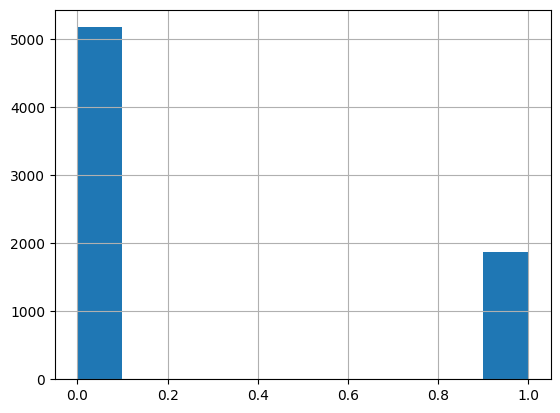

In [0]:
# On vérifie la nouvelle composition de notre variable cible par l'intermédiaire d'un histogramme
# On peut aussi le faire avec la fonction 'value_counts'

import matplotlib.pyplot as plt 

data['Churn'].hist()

plt.show()

In [0]:
# On supprime ici la colonne ID qui ne nous aidera pas dans notre modèle d'apprentissage automatique

data.drop(['customerID'], axis =1, inplace=True)

In [0]:
data_features = data.drop(['Churn'], axis = 1)
data_features.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65


<Axes: >

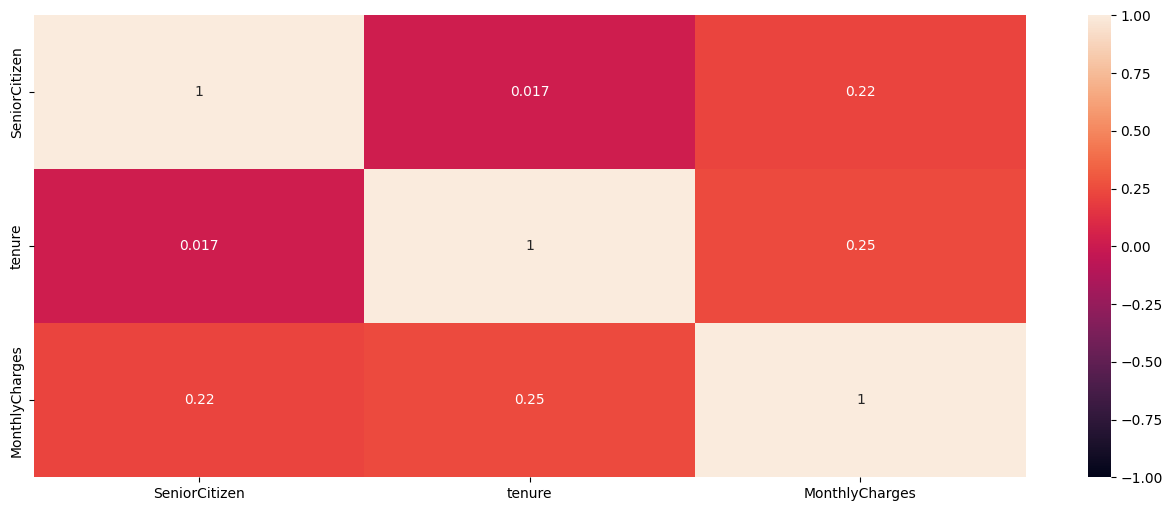

In [0]:
# On vérifie la corrélation entre les quelques variables numériques de notre dataset 

num_vars = list(data_features.select_dtypes(include=['int64','float64']))
corr = data_features[num_vars].corr()
plt.figure(figsize=(16, 6))
sns.heatmap(data = corr, vmin=-1, vmax=1, annot=True)

Nous n'avons pas besoin ici d'encoder avec l'aide de la propriété 'pd.get_dummies' les données catégorielles car cet étape est intégré automatiquement dans le modèle CatBoost que l'on va utiliser ici 

In [0]:
%pip install catboost

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
cat_vars = list(data_features.select_dtypes(include=['object']))

data_features = pd.get_dummies(data_features, columns=cat_vars, drop_first=True)

data_features.head()

,SeniorCitizen,tenure,MonthlyCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TotalCharges_100.2,TotalCharges_100.25,TotalCharges_100.35,TotalCharges_100.4,TotalCharges_100.8,TotalCharges_100.9,TotalCharges_1001.2,TotalCharges_1001.5,TotalCharges_1003.05,TotalCharges_1004.35,TotalCharges_1004.5,...,TotalCharges_973.35,TotalCharges_973.45,TotalCharges_973.55,TotalCharges_973.65,TotalCharges_973.95,TotalCharges_978,TotalCharges_978.6,TotalCharges_979.05,TotalCharges_979.5,TotalCharges_98.35,TotalCharges_98.5,TotalCharges_980.35,TotalCharges_981.45,TotalCharges_982.95,TotalCharges_985.05,TotalCharges_987.95,TotalCharges_989.05,TotalCharges_989.45,TotalCharges_99.45,TotalCharges_99.6,TotalCharges_99.75,TotalCharges_99.95,TotalCharges_990.3,TotalCharges_990.45,TotalCharges_990.85,TotalCharges_990.9,TotalCharges_992.7,TotalCharges_993.15,TotalCharges_994.55,TotalCharges_994.8,TotalCharges_995.35,TotalCharges_996.45,TotalCharges_996.85,TotalCharges_996.95,TotalCharges_997.65,TotalCharges_997.75,TotalCharges_998.1,TotalCharges_999.45,TotalCharges_999.8,TotalCharges_999.9
0,0,1,29.85,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,0,34,56.95,True,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,0,2,53.85,True,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,0,45,42.30,True,False,False,False,True,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,0,2,70.70,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,F

In [0]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X = data_features # Variables explicatives 
y = data['Churn'] # Variable cible 

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = CatBoostClassifier(
    iterations=500,            # nombre d'arbres
    learning_rate=0.05,        # taux d'apprentissage
    depth=5,                   # profondeur des arbres
    loss_function='Logloss',   
    eval_metric='Accuracy',          # Métrique d'évaluation du modèle 
    verbose=100,               
    random_state=42
)

# Entraînement
model.fit(X_train, y_train) 

# Prédiction
y_pred = model.predict(X_test)

# Probabilité qu'un client résilie son abonnement 
y_proba = model.predict_proba(X_test)[:, 1]

# Évaluation
print("Classification Report :\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

0:	learn: 0.7720980	total: 7.17ms	remaining: 3.58s
100:	learn: 0.8083067	total: 659ms	remaining: 2.6s
200:	learn: 0.8107916	total: 1.38s	remaining: 2.06s
300:	learn: 0.8115016	total: 2.04s	remaining: 1.35s
400:	learn: 0.8118566	total: 2.77s	remaining: 684ms
499:	learn: 0.8122116	total: 3.43s	remaining: 0us
Classification Report :
               precision    recall  f1-score   support

           0       0.84      0.92      0.88      1036
           1       0.69      0.51      0.59       373

    accuracy                           0.81      1409
   macro avg       0.77      0.71      0.73      1409
weighted avg       0.80      0.81      0.80      1409

Accuracy: 0.8105039034776437


In [0]:
X1 = X_test.copy()
X1['Churn_predict'] = y_pred
X1['Churn_proba'] = y_proba
X1.head()
# La création de ce dataset (X1) nous permet de visualiser le score (probabilité) attribué par le modèle à chaque client de résilier son abonnement et également la prédiction associé par le modèle.

,SeniorCitizen,tenure,MonthlyCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TotalCharges_100.2,TotalCharges_100.25,TotalCharges_100.35,TotalCharges_100.4,TotalCharges_100.8,TotalCharges_100.9,TotalCharges_1001.2,TotalCharges_1001.5,TotalCharges_1003.05,TotalCharges_1004.35,TotalCharges_1004.5,...,TotalCharges_973.55,TotalCharges_973.65,TotalCharges_973.95,TotalCharges_978,TotalCharges_978.6,TotalCharges_979.05,TotalCharges_979.5,TotalCharges_98.35,TotalCharges_98.5,TotalCharges_980.35,TotalCharges_981.45,TotalCharges_982.95,TotalCharges_985.05,TotalCharges_987.95,TotalCharges_989.05,TotalCharges_989.45,TotalCharges_99.45,TotalCharges_99.6,TotalCharges_99.75,TotalCharges_99.95,TotalCharges_990.3,TotalCharges_990.45,TotalCharges_990.85,TotalCharges_990.9,TotalCharges_992.7,TotalCharges_993.15,TotalCharges_994.55,TotalCharges_994.8,TotalCharges_995.35,TotalCharges_996.45,TotalCharges_996.85,TotalCharges_996.95,TotalCharges_997.65,TotalCharges_997.75,TotalCharges_998.1,TotalCharges_999.45,TotalCharges_999.8,TotalCharges_999.9,Churn_predict,Churn_proba
185,0,1,24.80,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,0.713081
2715,0,41,25.25,True,False,False,True,False,True,False,True,True,False,True,False,True,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,0,0.063335
3825,0,52,19.35,False,True,True,True,False,False,False,True,True,False,True,False,True,False,True,False,True,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0.014701
1807,0,1,76.35,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,0.835469
132,0,67,50.55,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,

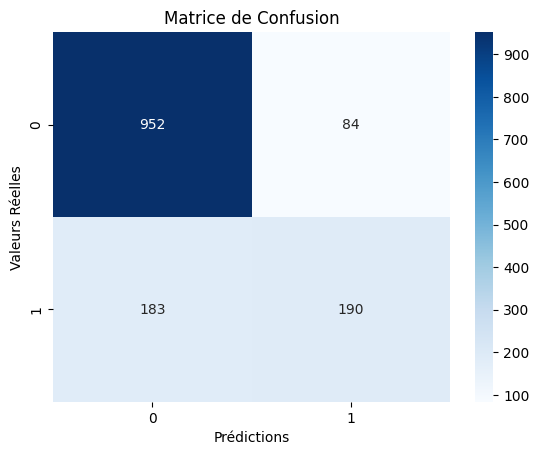

In [0]:
conf_matrix = confusion_matrix(y_test,y_pred)
sns.heatmap(conf_matrix,annot=True,fmt='d',cmap='Blues')
plt.title("Matrice de Confusion")
plt.xlabel("Prédictions")
plt.ylabel("Valeurs Réelles")
plt.show()

Une fois notre modèle implémenter avec un accuracy de 0.81, on estime que notre modèle est juste. Maintenant nous souhaitons savoir quels sont les variables les plus influentes afin de pouvoir faire une segmentation et créer un profil type des clients qui ont résilier leur contrat.

In [0]:
%pip install shap

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import shap 

explainer = shap.TreeExplainer(model)  
shap_values = explainer.shap_values(data_features) 

# SHAP pour la classe risquée (Churn égale à 1)
shap_values_risky = shap_values[1]  

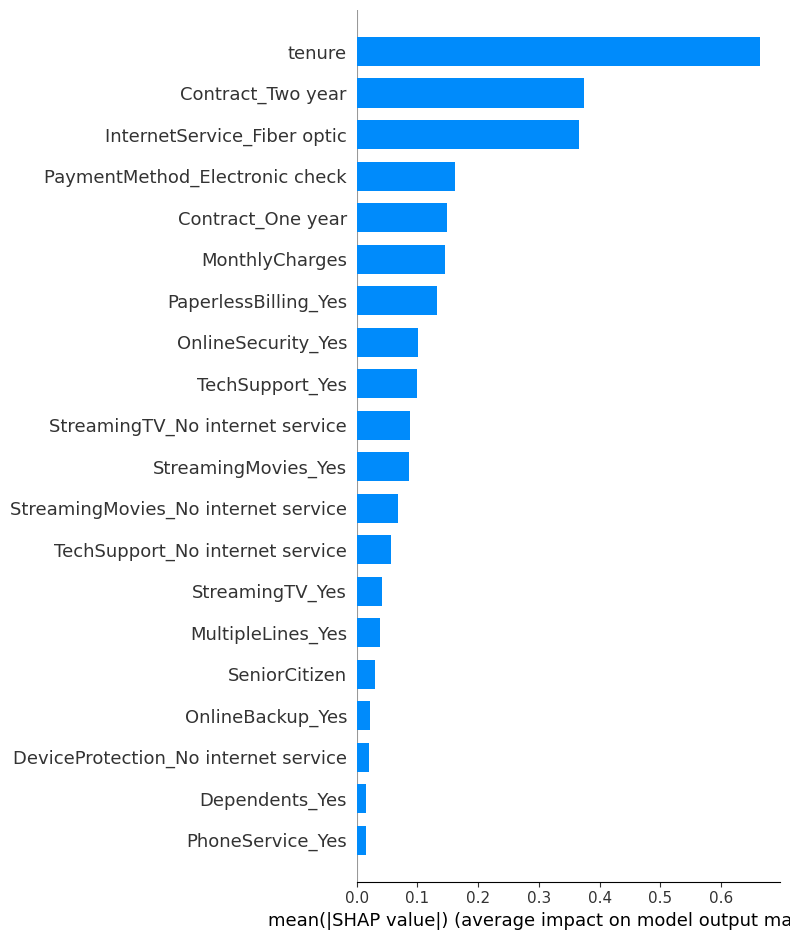

In [0]:
shap.summary_plot(shap_values, data_features, plot_type="bar")

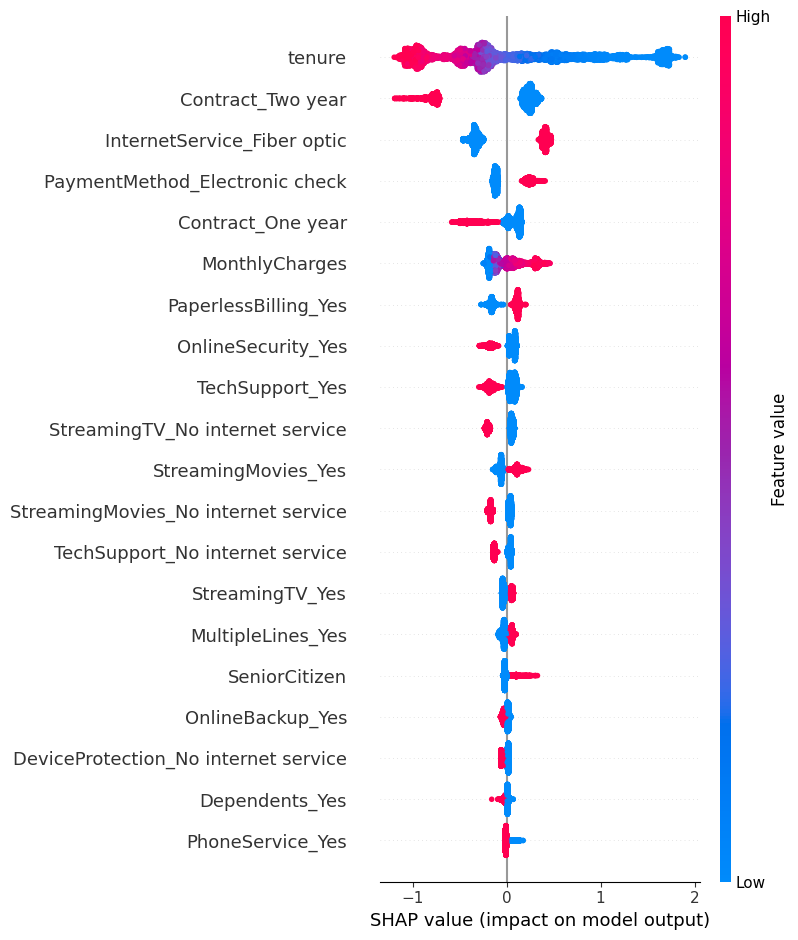

In [0]:
shap.summary_plot(shap_values, data_features)

Avec ces deux visualisations on peut donc "créer" un profil type de client qui a le plus de chance de résilier son contrat dans le futur. 

Le client type qui a de fortes chances de résilier possède quelques-unes de ces caractéristiques :
- nombre de mois conséquent d'appartenance à l'entreprise
- un contrat de 2 ans
- possède une fibre optic 
- utlise le check electronique comme moyen de paiement 
- mensualité élevée 


L'apprentissage de ces données historiques permettent d'établir les caractéristiques des clients qui ont une forte probabilité de résilier leur abonnement pour anticiper les prochaines résiliations et donc aiguiller les équipes marketings sur les offres à mettre en place (ou à conserver) afin de réduire au maximum le taux de churn et/ou établir une stratégie de fidélisation.